In [2]:
import sys, os
sys.path.insert(0,"/home/zhi/SULI21")
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.integrate import simps
import matplotlib.pyplot as plt
import quasim as qua
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import pandas as pd
from scipy.optimize import curve_fit
import math

In [2]:
# Find corresponding timestamp for each phase.
# Some initial setup of simulation:

QT = qua.QuaTel()
# Process the BSC to array of stars
# Output as [[star_num1,RA1,DEC1,S1],[star_num2,RA2,DEC2,S2],....] 
# in rad and Jy, S is in V-band
BSC = qua.BSC_process("/home/zhi/SULI21/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.30004,0.71,6.4*10**(6)]]
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample pos, here I use sample pos[0] as a sample star
print(pos[16])
T = 3000  # try for 3000s first

[[5.06200000e+03 3.51345687e+00 9.59722619e-01 9.05944064e+01]
 [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]


In [88]:
num, t, baseline, theo_phase = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
f_t, new_t = QT.freq_func(theo_phase,t)
num = num[0] # Lets simulate data for one star only, and implement multiple stars if needed
theo_phase = theo_phase[0]
# We have the theoretical phase term and t term,
# Match the phase term within some number and select out the corresponidng timestamp.

theo_phase = np.mod((theo_phase + np.pi),2*np.pi) - np.pi
V = (2*pos[16][0,3]*pos[16][1,3])/(pos[16][0,3]+pos[16][1,3])**(2)
avg_res_rate = (np.amax(num) + np.amin(num))/2
print(avg_res_rate)

0.015626569686660773


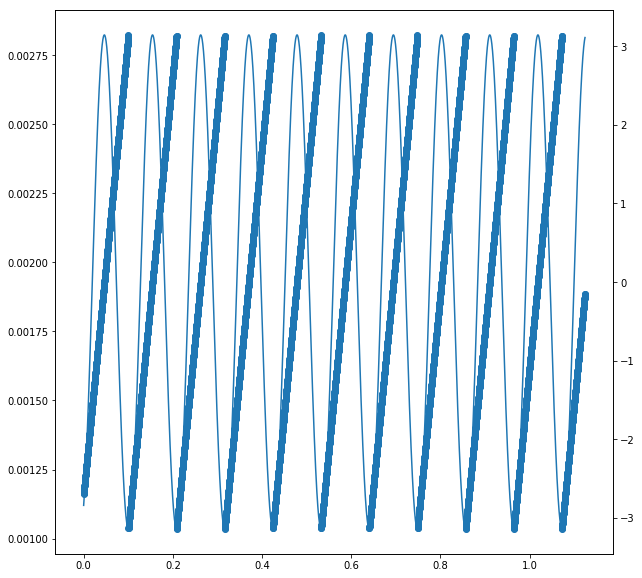

In [635]:
fig, ax1 = plt.subplots(figsize=(10,10))
#plt.xlim([])
ax2 = ax1.twinx()
ax1.plot(t[:10000],num[:10000])
ax2.scatter(t[:10000],theo_phase[:10000])

In [99]:
#  Generate Simulated data:

#V = 1
def pdf(x,V):
    return (1+ V*np.cos(x))/(2*np.pi)

def cdf(x,V):
    return (x+np.pi+V*np.sin(x))/(2*np.pi)



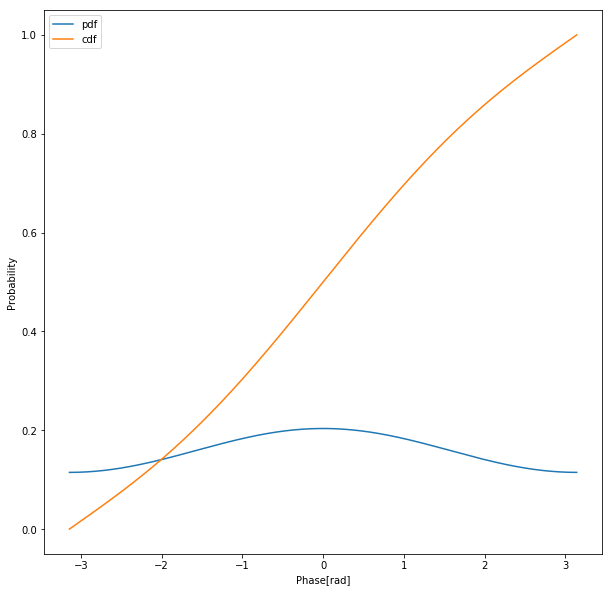

In [100]:
x = np.linspace(-np.pi,np.pi,600)

plt.figure(figsize=(10,10))
#plt.ylim([0.15915,0.15916])
plt.plot(x,pdf(x,V),label='pdf')    #suppose star pair has flux density of 1.5 and 3 respectively
plt.plot(x,cdf(x,V),label='cdf')
plt.xlabel('Phase[rad]');plt.ylabel('Probability')
plt.legend()

In [101]:
# find corresponding phi 
N = 1000
r = np.random.random(N)  # value for cdf, each number is for each cycle
a = np.full(shape= N, fill_value = np.pi+0.5)
b = np.full(shape= N, fill_value = -np.pi-0.5)

In [113]:
# Find roots for N - equations
# condition: f(a)*f(b) < 0 otherwise it is not guarantteed 


def inverse_cdf(r,a,b,V):
    def inverse_cdf_func(x,r,V):
        return (x+V*np.sin(x)+np.pi)/(2*np.pi) - r
    
    if (inverse_cdf_func(a,r,V)*inverse_cdf_func(b,r,V) >= 0).any():
        print("bisection method failed")
        return None
    
    a_n = a
    b_n = b
    m_n = (a_n + b_n)/2
    f_m_n = inverse_cdf_func(m_n, r, V)    #where we have len(r) equations, or len(r) 1-D array
    
    while (np.absolute(f_m_n) > 0.00001).any():
    #for i in range(100):   
        f_a_n = inverse_cdf_func(a_n, r, V)
        f_b_n = inverse_cdf_func(b_n, r, V)
        cond1 = np.where(f_a_n*f_m_n < 0) 
        cond2 = np.where(f_b_n*f_m_n < 0)
        b_n[cond1] = m_n[cond1]
        a_n[cond2] = m_n[cond2]
        m_n = (a_n+b_n)/2
        f_m_n = inverse_cdf_func(m_n, r, V)
        
    return m_n

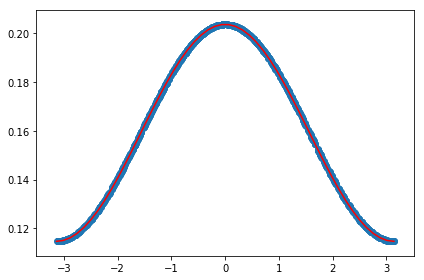

In [114]:
phase = inverse_cdf(r,a,b,V)
#phase_plot = np.delete(phase, np.where(np.abs(phase) > np.pi))

# for abs(phase) greater than pi set to nan 
#phase[np.where(np.abs(phase) > np.pi)] = np.nan

#print(np.where(np.isnan(phase)))
x = np.linspace(-np.pi,np.pi,50)

fig, ax = plt.subplots()
ax.plot(x, pdf(x,V), color = 'red')
ax.scatter(phase,pdf(phase,V))
fig.tight_layout()
plt.show()

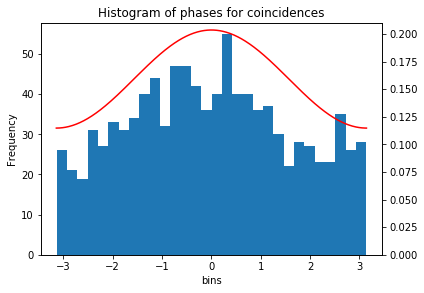

In [115]:
fig, ax1 = plt.subplots()
ax1.hist(phase,bins = 30)
plt.xlabel('bins');plt.ylabel('Frequency')
x = np.linspace(-np.pi, np.pi,500)
ax2 = ax1.twinx()
ax2.plot(x, pdf(x,V), color = 'red')
plt.ylim([0,0.21])
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences')
plt.show()     

In [116]:
# divide up theo_phase from current phase to next pi phase, 

#condition to find end point of cycle
cond = np.asarray(np.where((num-np.amin(num)) < 0.001*avg_res_rate))

#condition to eliminate extra points
cond1 = np.asarray(np.where(np.diff(cond) == 1))

# indices for theo_phase ~ pi
cond = np.delete(cond, cond1)
#pi_phase = theo_phase[cond[0],cond[1]]

# Split array at each pi, we have N arrays each correspond to one cycle
phase_split = np.asarray(np.split(theo_phase, cond))
t_split = np.asarray(np.split(t,cond))
print(phase_split.shape)
# Find the total time for a cycle and multiply by average pair rate to get avg # coincidence

#timestamp corresponds to randomly generated phase
cycle_period= np.zeros(len(phase_split))


# Find the period of each cycle
for i in range(len(phase_split)):
    cycle_period[i] = abs(t_split[i][0]-t_split[i][-1])


print(cycle_period[:100])



(138466,)
[0.01618898 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237227 0.02225985
 0.02225985 0.02225985 0.02237227 0.02225985 0.02225985 0.02225985
 0.02237227 0.02225985 0.02225985 0.02225985 0.02237

In [425]:
# Poisson distribution
avg_num = avg_res_rate*cycle_period   #get average number per cycle
poi = np.random.poisson(avg_num)    #poisson number, # of occurence for each cycle

# Inverse cdf to find random phases 
r = np.random.random(np.sum(poi))   #np.sum(poi), total number of occurence
a = np.full(shape= np.sum(poi), fill_value = np.pi+0.5)
b = np.full(shape= np.sum(poi), fill_value = -np.pi-0.5)
phase = inverse_cdf(r,a,b,V)   #size of sum(poi)
#print(phase)

timestamp = np.zeros(np.sum(poi))

# Find timestamp for all phase
i = 0
cond = np.where(poi > 0)
for j in range(cond[0].size):    # j-th cycle
    for k in range(poi[cond][j]):
        indices = np.abs(phase[i] - phase_split[cond][j]).argmin()
        timestamp[i] = t_split[cond][j][indices]
        i += 1

# delete all invalid cycles with 0 occurence
#phase = np.delete(phase, np.where(poi == 0) )
#timestamp = np.delete(timestamp, np.where(poi == 0))

print(timestamp.size == np.sum(poi))


True


In [420]:
timestamp[299:303]

array([977.30870619, 982.86950901, 982.86242633, 984.04107414])

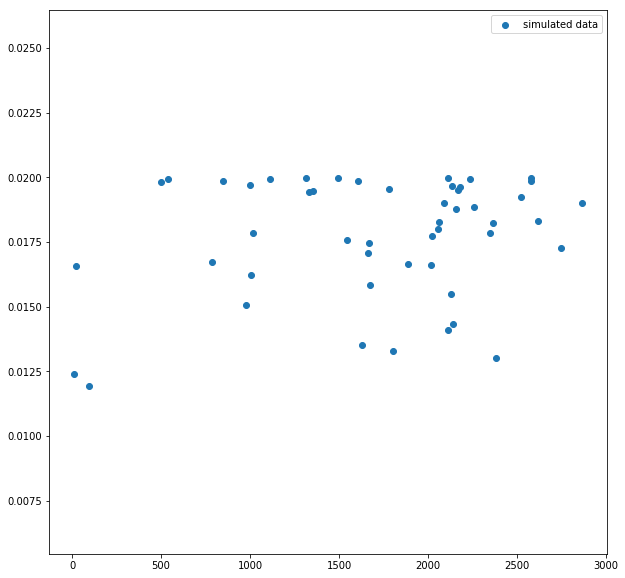

In [426]:
plt.figure(figsize=(10,10))
#plt.xlim([982,983])
plt.scatter(timestamp,pdf(phase,V)*2*np.pi*avg_res_rate, label ='simulated data')
#plt.plot(t[2000000:],num[2000000:], label = 'theoretical curve')
plt.legend()

In [4]:
# TEST FOR new compact code:
num, t, baseline, theo_phase = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
f_t, new_t = QT.freq_func(theo_phase,t)
num = num[0] # Lets simulate data for one star only, and implement multiple stars if needed
theo_phase = theo_phase[0]


In [29]:
#sim_data = qua.sim_data(N,s,avg_rate,'pos')
sim_data = qua.sim_data(num,t,theo_phase,'pos')


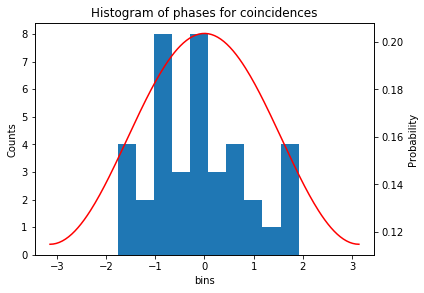

In [30]:

fig, ax1 = plt.subplots()
ax1.hist(sim_data.phase,bins = 10)
plt.xlabel('bins');plt.ylabel('Counts')
ax2 = ax1.twinx()
plt.ylabel('Probability')
ax2.plot(sim_data.x, sim_data.pdf_value, color = 'red')
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences')
plt.show()     

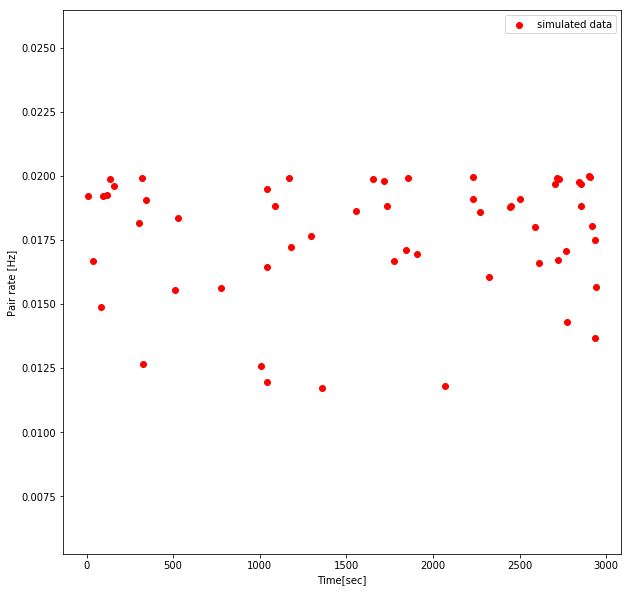

In [12]:
plt.figure(figsize=(10,10))
#plt.xlim([391.8,395.5]);plt.ylim([0.011,0.021])
plt.scatter(sim_data.timestamp,sim_data.sim_num, color='r', label ='simulated data')
#plt.plot(t[:4000000],num[:4000000], label = 'theoretical curve')
plt.xlabel('Time[sec]');plt.ylabel('Pair rate [Hz]')
plt.legend()

[0.21999301 0.79701143 0.93120636 0.27745491 0.04860847 0.83114438
 0.56321889 0.01535855 0.53570378 0.06233236]
[-1.46114349  1.56616378  2.53940743 -1.12730119 -2.71094058  1.78765103
  0.30664259 -3.00394165  0.17278339 -2.5936957 ]


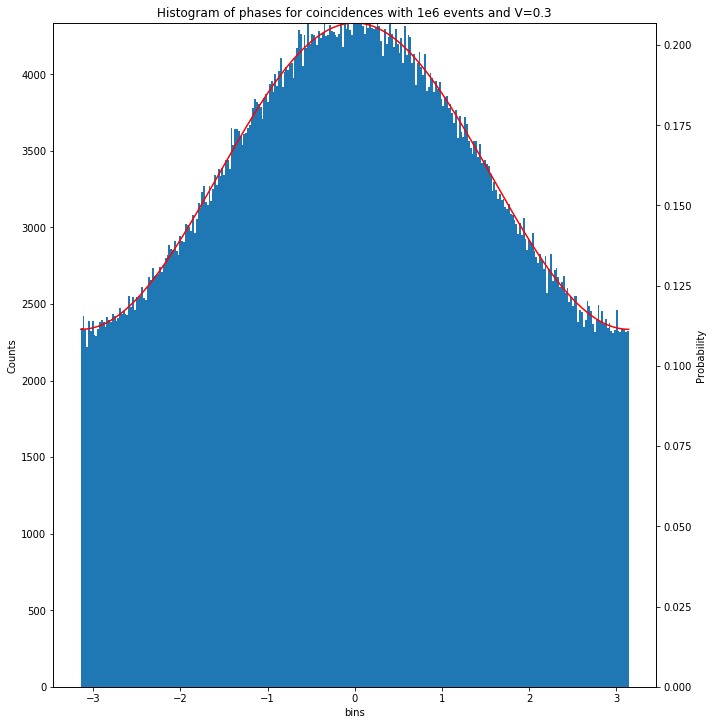

In [32]:
# Follow UP: TASK 1
# Draw 1e6 events for V=0.3 plot histogram, CHECK
def pdf(x,V):
    return (1+ V*np.cos(x))/(2*np.pi)

def cdf(x,V):
    return (x+np.pi+V*np.sin(x))/(2*np.pi)

V = 0.3

def inverse_cdf(r,a,b,V):
    def inverse_cdf_func(x,r,V):
        return (x+V*np.sin(x)+np.pi)/(2*np.pi) - r
    
    if (inverse_cdf_func(a,r,V)*inverse_cdf_func(b,r,V) >= 0).any():
        print("bisection method failed")
        return None
    
    a_n = a
    b_n = b
    m_n = (a_n + b_n)/2
    f_m_n = inverse_cdf_func(m_n, r, V)    #where we have len(r) equations, or len(r) 1-D array
    
    while (np.absolute(f_m_n) > 0.00001).any():
    #for i in range(100):   
        f_a_n = inverse_cdf_func(a_n, r, V)
        f_b_n = inverse_cdf_func(b_n, r, V)
        cond1 = np.where(f_a_n*f_m_n < 0) 
        cond2 = np.where(f_b_n*f_m_n < 0)
        b_n[cond1] = m_n[cond1]
        a_n[cond2] = m_n[cond2]
        m_n = (a_n+b_n)/2
        f_m_n = inverse_cdf_func(m_n, r, V)
        
    return m_n

N = 1000000
r = np.random.random(N)  # value for cdf, each number is for each cycle
print(r[:10])
a = np.full(shape= N, fill_value = np.pi+0.5)
b = np.full(shape= N, fill_value = -np.pi-0.5)

phase = inverse_cdf(r,a,b,V)
print(phase[:10])
x = np.linspace(-np.pi,np.pi,500)
h, w =np.histogram(phase,bins = 300)
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.hist(phase,bins = 300)
plt.xlabel('bins');plt.ylabel('Counts')
plt.ylim([0,h[int(h.size/2)]])
ax2 = ax1.twinx()
plt.ylabel('Probability')
ax2.plot(x, pdf(x,V), color = 'red')
plt.ylim([0,np.amax(pdf(x,V))])
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences with 1e6 events and V=0.3')
plt.show()

In [231]:
# TASK 2: Fix the period of each cycle to be fixed in time, increase coincidence rate to 10Hz, then find timestamp
# then FFT and square.


# Let frequency to be fixed at at 45Hz, for 300sec 

avg_rate = 100.0  # 200Hz
t = np.arange(0,300, (0.001/45.0))
V = 0.3
def func(t,avg_rate,V):
    return avg_rate*(1+V*np.cos(2*np.pi*45.0*t))

def theo_phase(t):
    return 2*np.pi*45.0*t

num = func(t,avg_rate,V)
theo_phase = theo_phase(t)

task2 = qua.sim_data(num,t,theo_phase,'pos')



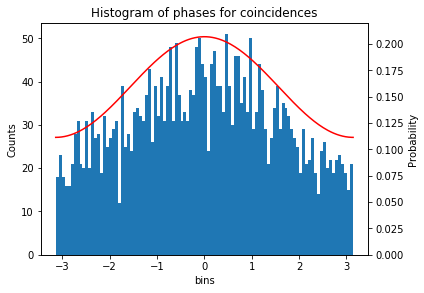

In [39]:
# TASK 2 CONTINUED


fig, ax1 = plt.subplots()
ax1.hist(task2.phase,bins = 100)
plt.xlabel('bins');plt.ylabel('Counts')
ax2 = ax1.twinx()
plt.ylabel('Probability')
ax2.plot(task2.x, task2.pdf_value, color = 'red')
plt.ylim([0,0.22])
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences')
plt.show()   

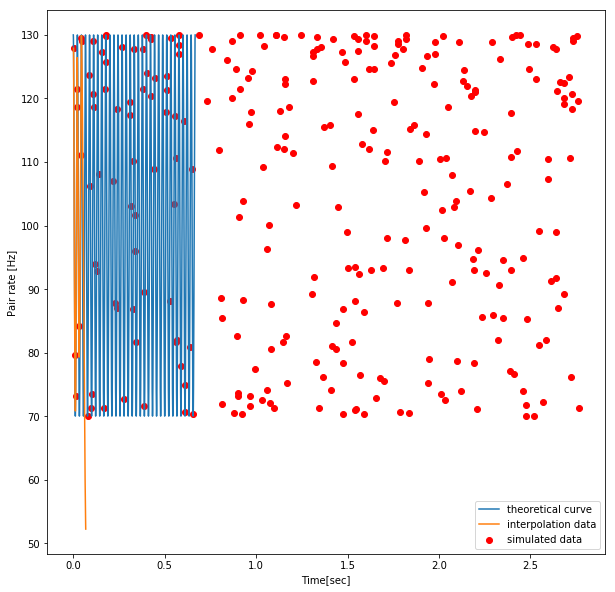

In [174]:
timestamp = np.delete(task2.timestamp, np.where(np.diff(task2.timestamp) == 0))
sim_num = np.delete(task2.sim_num, np.where(np.diff(task2.timestamp) == 0))

interp = interp1d(timestamp,sim_num, kind = 'cubic', fill_value="extrapolate")
interp_t = np.arange(timestamp[0], timestamp[-1], (0.001/45.0))


plt.figure(figsize=(10,10))
#plt.xlim([0.01,0.02])
plt.scatter(timestamp[:300],sim_num[:300], color='r', label ='simulated data')
plt.plot(t[:30000],num[:30000], label = 'theoretical curve')
plt.plot(interp_t[:3000], interp(interp_t)[:3000], label = 'interpolation data')
plt.plot()
plt.xlabel('Time[sec]');plt.ylabel('Pair rate [Hz]')
plt.legend()

In [175]:
#TASK 2 CONTINUED: FFT of interpolated data

N = interp_t.size                
sample_period = (0.001/45.0)

fft = np.fft.fft(interp(interp_t) - avg_rate)                  
fft_amp = np.absolute(fft)                           #amplitude spectrum.
fft_freq = np.fft.fftfreq(N, d = sample_period)       #(N)


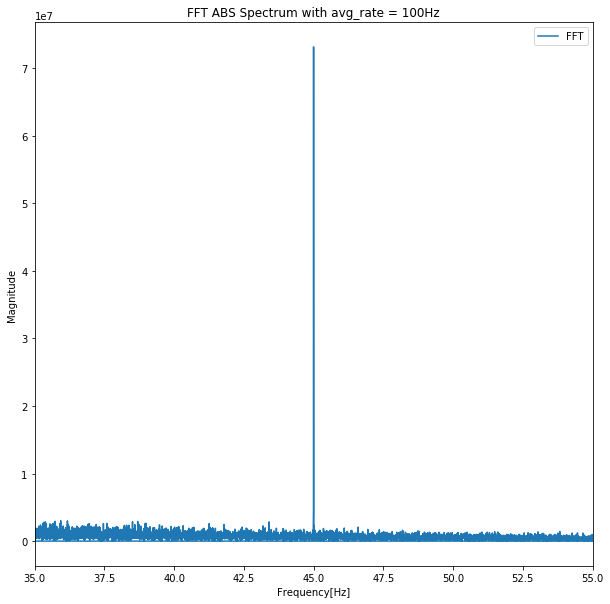

In [176]:

plt.figure(figsize=(10,10))
plt.plot(fft_freq,fft_amp, label = 'FFT')
plt.xlabel('Frequency[Hz]');plt.ylabel('Magnitude')
plt.title('FFT ABS Spectrum with avg_rate = 100Hz')
plt.xlim([35,55])
plt.legend()


('sample spacing:', array([0.00986931]), '/n average counts within each time bin:', 0.999967103098888)


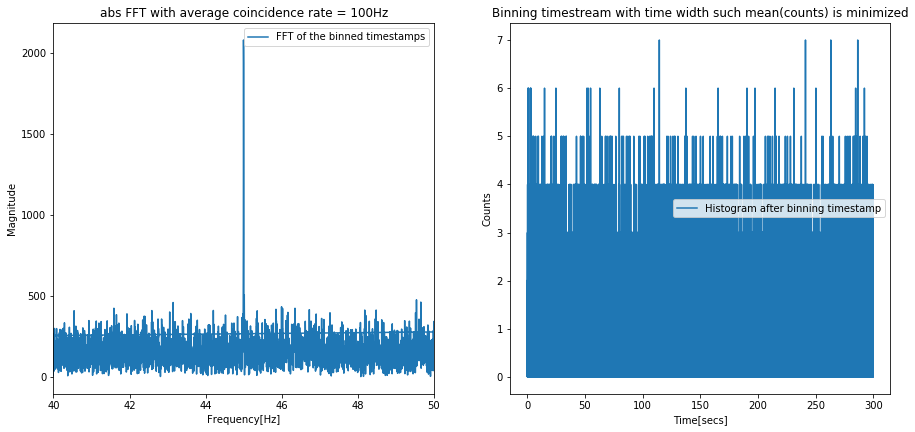

In [238]:
# TASK 2 OTHER APPROACH: BIN EVENTS IN EACH CYCLE: number of events in each cycle then FFT

# Binning the tmestamp 
def meanh(spacing):
    x = np.arange(0,300,spacing)
    nbin = abs(int(300/spacing))
    h, w = np.histogram(task2.timestamp,bins = nbin+1)
    return np.mean(h)

res = minimize(meanh, (np.average(np.diff(task2.timestamp))), method='CG')
    

x = np.arange(0,300,res.x)
nbin = int(300/res.x)
h, w = np.histogram(task2.timestamp,bins = nbin+1)

print('sample spacing:', res.x, '/n average counts within each time bin:', np.mean(h))

M = h.size
fft = np.fft.fft(h - np.mean(h)) 
fft_amp = np.absolute(fft)
fft_freq = np.fft.fftfreq(M, d= res.x)



plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(fft_freq, fft_amp,label = 'FFT of the binned timestamps')
plt.xlabel('Frequency[Hz]');plt.ylabel('Magnitude')
plt.title('abs FFT with average coincidence rate = 100Hz')
plt.xlim([40,50])
plt.legend()

plt.subplot(2,2,2)
plt.plot(x,h,label='Histogram after binning timestamp')
plt.xlabel('Time[secs]');plt.ylabel('Counts')
plt.title('Binning timestream with time width such mean(counts) is minimized')
plt.legend()

array([0.00999995])

In [7]:
#TASK3 SAME AS TASK2, but varying the frequency
QT = qua.QuaTel()
BSC = qua.BSC_process("/home/zhi/SULI21/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.30004,0.71,6.4*10**(6)]]
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample pos, here I use sample pos[0] as a sample star
print(pos[16])
T = 300  # try for 3000s first

num, t, baseline, theo_phase = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
f_t, new_t = QT.freq_func(theo_phase,t)
num = num[0] # Lets simulate data for one star only, and implement multiple stars if needed
theo_phase = theo_phase[0]



task3 = qua.sim_data(num*10000.0,t,theo_phase,'pos')    #increase avg_rate by 10,000

[[5.06200000e+03 3.51345687e+00 9.59722619e-01 9.05944064e+01]
 [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]


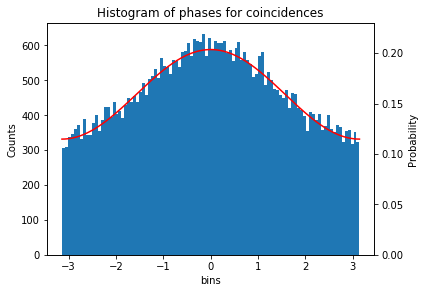

In [27]:
fig, ax1 = plt.subplots()
ax1.hist(task3.phase,bins = 100)
plt.xlabel('bins');plt.ylabel('Counts')
#plt.ylim([0,620])
ax2 = ax1.twinx()
plt.ylabel('Probability')
ax2.plot(task3.x, task3.pdf_value, color = 'red')
plt.ylim([0,0.23])
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences')
plt.show()   

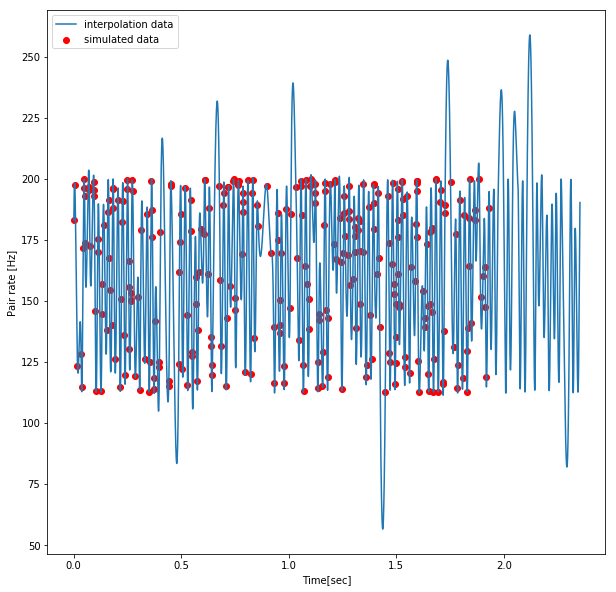

In [46]:
timestamp = np.delete(task3.timestamp, np.where(np.diff(task3.timestamp) == 0))
sim_num = np.delete(task3.sim_num, np.where(np.diff(task3.timestamp) == 0))

interp = interp1d(timestamp,sim_num, kind = 'cubic')
interp_t = np.arange(timestamp[0], timestamp[-1], (0.001/85.0))


plt.figure(figsize=(10,10))
#plt.xlim([31.5,31.8])
plt.scatter(timestamp[:300],sim_num[:300], color='r', label ='simulated data')
#plt.plot(t[:10000],num[:10000], label = 'theoretical curve')
plt.plot(interp_t[:200000], interp(interp_t)[:200000], label = 'interpolation data')
plt.plot()
plt.xlabel('Time[sec]');plt.ylabel('Pair rate [Hz]')
plt.legend()

In [47]:
N = interp_t.size                
sample_period = (0.001/85.0)

fft = np.fft.fft(interp(interp_t) - task3.avg_rate)                     #(M,N),
fft_amp = np.absolute(fft)                           #amplitude spectrum.
fft_freq = np.fft.fftfreq(N, d = sample_period)       #(N)


M = num.size
fft_theo = np.fft.fft(num - task3.avg_rate/10000.0) 
fft_theo_freq = np.fft.fftfreq(M, d= t[1]-t[0])

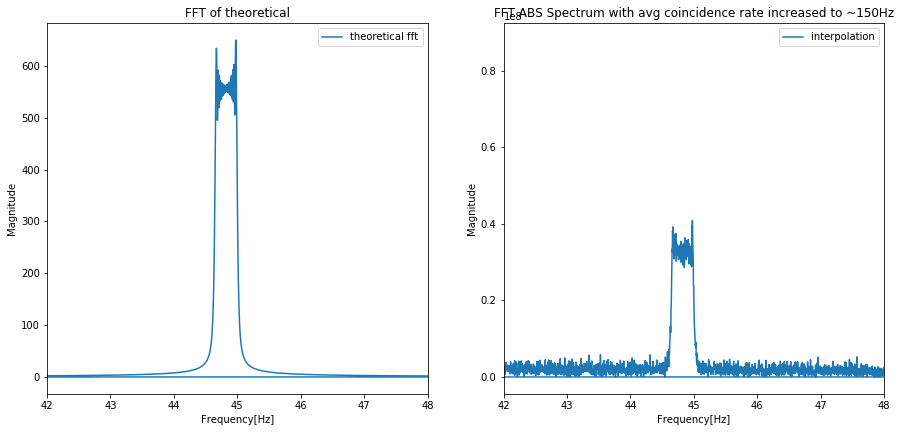

In [49]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
#plt.plot(fft_freq,fft_amp, label='interpolation')
plt.plot(fft_theo_freq, np.absolute(fft_theo), label = 'theoretical fft')
#plt.xlim([0,90])
plt.xlabel('Frequency[Hz]');plt.ylabel('Magnitude')
plt.title('FFT of theoretical')
plt.xlim([42,48])
plt.legend()
plt.subplot(2,2,2)
plt.plot(fft_freq,fft_amp, label='interpolation')
plt.xlabel('Frequency[Hz]');plt.ylabel('Magnitude')
plt.title('FFT ABS Spectrum with avg coincidence rate increased to ~150Hz')
plt.xlim([42,48])
plt.legend()

('sample spacing:', array([0.00645433]), '/n average counts within each time bin:', 0.9999139433316839)


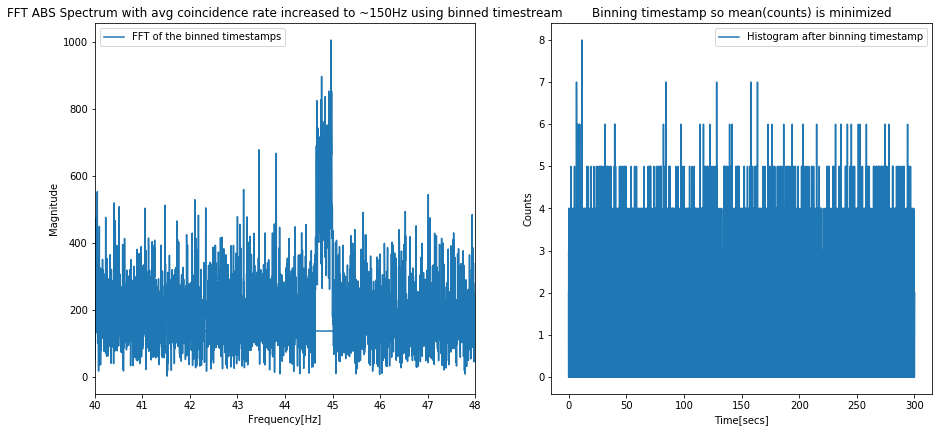

In [237]:
# TASK3 continued: Finding FFT by binning timestamp:

# Binning the tmestamp 

def meanh(spacing):
    x = np.arange(0,300,spacing)
    nbin = abs(int(300/spacing))
    h, w = np.histogram(task3.timestamp,bins = nbin+1)
    return np.mean(h)

res = minimize(meanh, (np.average(np.diff(task3.timestamp))), method='CG')
    
x = np.arange(0,300,res.x)
nbin = int(300/res.x)
h, w = np.histogram(task3.timestamp,bins = nbin+1)

print('sample spacing:', res.x, '/n average counts within each time bin:', np.mean(h))

M = h.size
fft = np.fft.fft(h - np.mean(h)) 
fft_amp = np.absolute(fft)
fft_freq = np.fft.fftfreq(M, d= res.x)



plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(fft_freq, fft_amp,label = 'FFT of the binned timestamps')
plt.xlabel('Frequency[Hz]');plt.ylabel('Magnitude')
plt.title('FFT ABS Spectrum with avg coincidence rate increased to ~150Hz using binned timestream')
plt.xlim([40,48])
plt.legend()

plt.subplot(2,2,2)
plt.plot(x,h,label='Histogram after binning timestamp')
plt.xlabel('Time[secs]');plt.ylabel('Counts')
plt.title('Binning timestamp so mean(counts) is minimized')
plt.legend()

In [2]:
# Third approach:
QT = qua.QuaTel()
BSC = qua.BSC_process("/home/zhi/SULI21/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.30004,0.71,6.4*10**(6)]]
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample pos, here I use sample pos[0] as a sample star
print(pos[16])
T = 30  # try for 3000s first

num, t, baseline, theo_phase = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
f_t, new_t = QT.freq_func(theo_phase,t)
num = num[0] # Lets simulate data for one star only, and implement multiple stars if needed
theo_phase = theo_phase[0]



[[5.06200000e+03 3.51345687e+00 9.59722619e-01 9.05944064e+01]
 [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]


4711


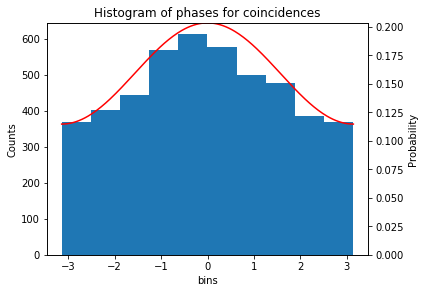

In [3]:
task4 = qua.sim_data(num*10000,t,theo_phase,'pos')   
print(task4.timestamp.size)

fig, ax1 = plt.subplots()
ax1.hist(task4.phase,bins = 10)
plt.xlabel('bins');plt.ylabel('Counts')
#plt.ylim([0,60])
ax2 = ax1.twinx()
plt.ylabel('Probability')
ax2.plot(task4.x, task4.pdf_value, color = 'red')
plt.ylim([0,np.amax(task4.pdf_value)])
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences')
plt.show()   

[0.25225225]


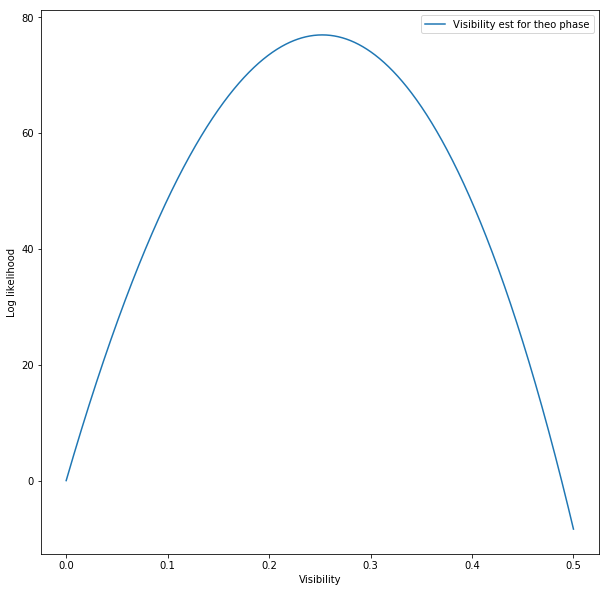

In [4]:
# Lets find ESTIMATED Visbility first, then use that to find parameters for omega
N = task4.phase.size

V = np.tile(np.linspace(0,0.5,1000),(N,1)).T
phase = np.tile(task4.phase,(1000,1))

def MLE(param,x):
    N = x.size
    def log_likelihood(phase,vis):
        return np.log(1 + vis*np.cos(phase))
    
    return np.sum(log_likelihood(x,param), axis = 1)


LLH = MLE(V,phase)
V_fit = V[:,0][np.where(LLH == np.amax(LLH))]

print(V_fit)

plt.figure(figsize=(10,10))
plt.plot(V[:,0], LLH, label='Visibility est for theo phase')
plt.xlabel('Visibility');plt.ylabel('Log likelihood')
plt.legend()

In [6]:
# Now vary omega but fix estimated visibility

# assume oscillation frequency varies like a sinuosidoal
def phase_func(t,A,w,theta):
    phase = -2*np.pi*A/w*np.cos(w*t+theta)
    #return np.mod((phase + np.pi),2*np.pi) - np.pi
    return phase

# let A, w, theta vary from maximum to minimum
N = 100
M = task4.timestamp.size
#,47.8255910,7.29199974e-05,1.20378777
Amax= np.linalg.norm(baseline)/lam*QT.Omega_E

#print( np.append(np.linspace(47.8255910+0.1,47.8255910-0.1, N),2))


A = np.ravel(np.tile(  np.append(np.linspace(47.8255910+5,47.8255910-5, N),47.8255910),(N**2,1)).T)
w = np.ravel(np.tile(  np.append(np.linspace(QT.Omega_E+0.2e-5, QT.Omega_E - 0.2e-5, N),QT.Omega_E) ,(N,N)).T)
theta = np.ravel(np.tile(  np.append(np.linspace(1.20378777+0.5,1.20378777-0.5, N), 1.20378777), (N**2)).T)
#V = np.tile(np.linspace(0., 0.5, N), (N**3))



#print(A)
#print(w)
#print(theta)
#print(V)


def sum_log_likelihood(t,A,w,theta,V):
    
    def phase_func(t,A,w,theta):
        return -2*np.pi*A/w*np.cos(w*t+theta)
    
    return np.sum(np.log(1 + V*np.cos(phase_func(t,A,w,theta))), axis=1)





arr_range = np.linspace(0,N**3,20).astype(int)
start_index = 0
sum_loglike = np.array([])

for end_index in arr_range[1:]:
    #print(start_index)
    #print(end_index)
    L = end_index - start_index  #newly divided, total of L parameter pairs
    timestamp = np.tile(task4.timestamp,(L,1))
    A_mat = np.tile(A[start_index:end_index],(M,1)).T
    w_mat = np.tile(w[start_index:end_index],(M,1)).T
    theta_mat = np.tile(theta[start_index:end_index],(M,1)).T
    #V_mat = np.tile(V[start_index:end_index],(M,1)).T
    
    #print(A_mat)
    #print(w_mat)
    #print(theta_mat)
    #print(V_mat)
    
    
    sum_loglike = np.concatenate((sum_loglike, sum_log_likelihood(timestamp,A_mat,w_mat,theta_mat,V_fit)), axis=None)
    
    start_index = end_index
    
    timestamp = None
    A_mat = None
    w_mat = None
    theta_mat = None
    #V_mat = None
    


In [11]:
cond = np.where(sum_loglike == np.amax(sum_loglike))
print('A =', A[cond],'w =', w[cond], 'theta =', theta[cond], ' V =', V_fit)
print(sum_loglike[cond])

('A =', array([45.75488393]), 'w =', array([7.30614141e-05]), 'theta =', array([1.35025242]), ' V =', array([0.25225225]))
[74.41800397]


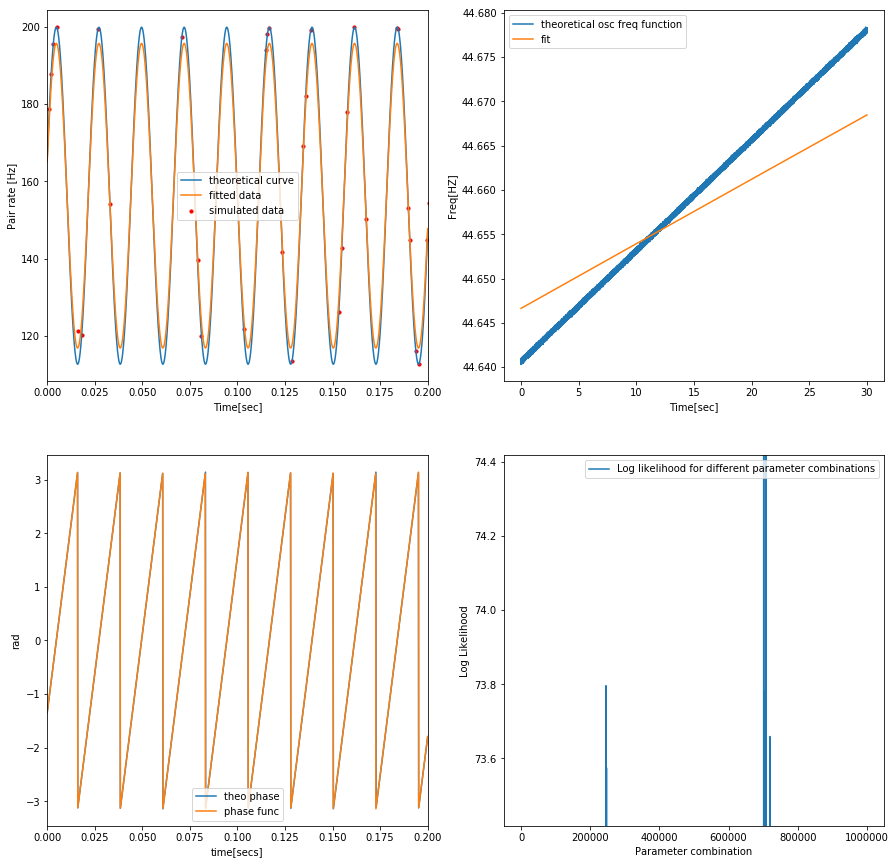

In [9]:
def freq_func(t,a,b,c):
    return a*np.sin(b*t+c)

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.xlim([0,0.2])
plt.scatter(task4.timestamp[:50],task4.sim_num[:50], s = 10, color='r', label ='simulated data')
plt.plot(t[:5000],num[:5000]*10000, label = 'theoretical curve')
plt.plot(t[:5000],task4.avg_rate*(1+V_fit*np.cos(phase_func(t[:5000],A[cond],w[cond],theta[cond]))), label = 'fitted data')
plt.xlabel('Time[sec]');plt.ylabel('Pair rate [Hz]')
plt.legend()

plt.subplot(2,2,2)
plt.plot(new_t, f_t[0], label = 'theoretical osc freq function')
plt.plot(new_t, freq_func(new_t, A[cond],w[cond],theta[cond]), label = 'fit')
plt.ylabel('Freq[HZ]');plt.xlabel('Time[sec]')
plt.legend()

plt.subplot(2,2,3)
plt.plot(t[:10000], np.mod((theo_phase[:10000]+ np.pi),2*np.pi) - np.pi, label='theo phase')
#plt.plot(t[:10000], np.mod((phase_func(t[:10000],A[cond],w[cond],theta[cond])+ np.pi),2*np.pi) - np.pi, label = 'phase func')
plt.plot(t[:10000], np.mod((phase_func(t[:10000],A[cond],w[cond],theta[cond])+ np.pi),2*np.pi) - np.pi, label = 'phase func')
plt.xlabel('time[secs]');plt.ylabel('rad')
plt.xlim([0,0.2])
plt.legend()



plt.subplot(2,2,4)
plt.plot(sum_loglike, label= 'Log likelihood for different parameter combinations')
plt.xlabel('Parameter combination');plt.ylabel('Log Likelihood')
plt.ylim([np.amax(sum_loglike)-1,np.amax(sum_loglike)])
plt.legend()


In [10]:
# Find maximum likelihood of phases?
# (1+V(cosx))/2pi, find V?
# only parameter = V
# minimize negative log likelihood:
def sum_log_likelihood(t,A,w,theta,V):
    
    def phase_func(t,A,w,theta):
        return -2*np.pi*A/w*np.cos(w*t+theta)
    
    return np.sum(np.log(1 + V*np.cos(phase_func(t,A,w,theta))), axis=0)


def MLE(param,x):
    N = x.size
    def log_likelihood(phase,vis):
        return np.log(1 + vis*np.cos(phase))
    
    return -np.sum(log_likelihood(x,param))

ini_guess = 0.3
res = minimize(MLE, ini_guess,args = (task4.phase), method = 'Nelder-Mead')
print(res.x)
print(task4.V)
print(task4.avg_rate)

theo_log = sum_log_likelihood(task4.timestamp,47.8255910,7.29199974e-05,1.20378777,res.x[0])
print(theo_log)
log = sum_log_likelihood(task4.timestamp,A[cond],w[cond],theta[cond],res.x[0])
log


[0.25236328]
0.279045277405243
156.26569686674202
75.29074190774958


74.41671956586025

In [10]:
def pdf(x,V):
    return (1+ V*np.cos(x))/(2*np.pi)

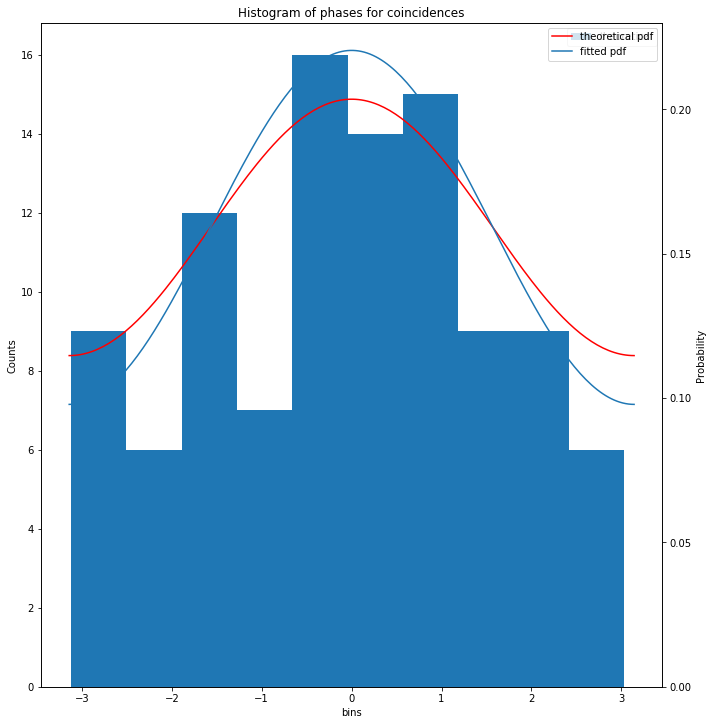

In [90]:

fig, ax1 = plt.subplots(figsize=(10,10))
#ax1.hist(np.mod((phase_func(task4.timestamp,*LLH_res.x)+ np.pi),2*np.pi) - np.pi ,bins = 10, label='fitted')
ax1.hist(task4.phase, bins=10, label='theoretical')
plt.xlabel('bins');plt.ylabel('Counts')
plt.legend()
ax2 = ax1.twinx()
plt.ylabel('Probability')
ax2.plot(task4.x, task4.pdf_value, color = 'red',label='theoretical pdf')
ax2.plot(task4.x, pdf(task4.x,res.x[0]), label = 'fitted pdf')
plt.ylim([0,0.23])
fig.tight_layout()
ax1.set_title('Histogram of phases for coincidences')
plt.legend()
plt.show()   

In [10]:
# New approach vary separation vector between two sources: dx xhat+ dy yhat + dz zhat, and V, then find 
# Avaliable for multiple par set

# MLE for one set of par
# pos_t = (2,N,3)

QT = qua.QuaTel()
BSC = qua.BSC_process("/home/zhi/SULI21/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.30004,0.71,6.4*10**(6)]]   #Baseline vector in [RA,DEC,RADIUS]
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample pos, here I use sample pos[0] as a sample star
print('pos16',pos[16])
T = 300  # try for 3000s first

num, t, baseline, theo_phase, d_source = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
f_t, new_t = QT.freq_func(theo_phase,t)
num = num[0] # Lets simulate data for one star only, and implement multiple stars if needed
theo_phase = theo_phase[0]

task4 = qua.sim_data(num*10,t,theo_phase,'pos')   
print('theo_d',d_source[0,0,:])




def MLE(par, t, pos_s, pos_t, lam, d):    # par = [[v,pho,theta],[v,phi,theta],...], let it be (M,3) set of par
    
    vis = par[0]
    ds = np.array([par[1],par[2]])    # [ew,ns] [[theta,phi],[],[],[]...]   (M,2)

    def get_phase(t, ds, pos_s, pos_t,lam,d):       #pos:[[[ra,dec,r],[ra,dec,r]],[[],[]]]
        pos_t = np.array(pos_t)
        pos_t[:,1] = np.pi/2 - pos_t[:,1]   # baseline vector in spherical baseline [[phi,theta,r],[phi,theta,r]]
        pos_s = np.delete(pos_s,0, axis=1)
    
        pos_s[:,1] = np.pi/2 - pos_s[:,1]
        
        Omega_E = 7.292e-5
        lam = lam
        #let ds be differene of source unit vector
        #let baseline vector change as a func of time, + Omega instead of minus
    
        def pos_carte(pos, ti,d,source= None):
            # rotate baseline vector as func of time
            if (ti == 0.0).all() :   # for pos source
                x = np.sin(source[:,1])*np.cos(source[:,0])
                y = np.sin(source[:,1])*np.sin(source[:,0])
                z = np.cos(source[:,1])
               
                r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
                s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
                # close to theoretical d_ns and d_ew
                #d_ew = (s/r)*(source[0,0]-source[1,0])  # using midpoint
                #d_ew = np.sin(source[0,1])*source[0,0]-np.sin(source[1,1])*source[1,0]   #actual
                d_ew = s/r * pos[0]
                #d_ew = pos[0]
                
                #d_ns = (source[0,1] - source[1,1])  
                d_ns = pos[1]
                
                #converting to Earth coord
                #rotate around d_ew axis, y axis
                fin_z = (s/r)*d_ns
                new_x = (((z[0]+z[1])/2)/r)*d_ns    #multiplied by d_ew and d_ns
                
                # rotate around z axis
                phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
                fin_x = np.cos(np.pi/2 + phi)*new_x - np.sin(-(np.pi/2 + phi))*d_ew
                fin_y = np.sin(-(np.pi/2 + phi))*new_x + np.cos(np.pi/2 + phi)*d_ew
                
                new_pos = -np.array([fin_x,fin_y,fin_z])    # since theta hat points down
                diff = d-new_pos
                #return d
                print('diff',diff)
                new_pos += diff
                return new_pos
        
            N = ti.size 
            M = len(pos)
            new_t = np.tile(ti,(2,1))   # (2,N)
            
            pos_tile = np.tile(np.reshape(pos,(2,1,3)),(1,N,1))    #pos of telescope, 2,N,3
            
            new_pos = np.zeros((2,N,3))
            
            #change from spherical to cartesian
            new_pos[:,:,0] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.cos(pos_tile[:,:,0] + Omega_E*new_t)   #[x,y,z](t)
            new_pos[:,:,1] = pos_tile[:,:,2]*np.sin(pos_tile[:,:,1])*np.sin(pos_tile[:,:,0] + Omega_E*new_t)
            new_pos[:,:,2] = pos_tile[:,:,2]*np.cos(pos_tile[:,:,1])     

            return new_pos
    
        ds_car = pos_carte(ds, np.array([0.]), d,source = pos_s)                   #(3)
        
        new_pos_t = pos_carte(pos_t,t,d)           #(2,N,3)
        baseline = new_pos_t[1] - new_pos_t[0]      #(3,N)
        print('dscar',np.float64(ds_car))
        #print('baseline', baseline)
        dot = baseline[:,0]*ds_car[0] + baseline[:,1]*ds_car[1] + baseline[:,2]*ds_car[2]
        phase = 2*np.pi/lam*dot
        
        return phase
    
    phase = get_phase(t,ds,pos_s,pos_t,lam,d)
    loglike = np.log(1+vis*np.cos(phase))  #get loglike for diff phase in 2d array[[],[],[]...]
    
    
    return np.sum(loglike,axis= None ), phase

def theo_ds(pos):  #pos in [#,phi,dec,s] find midpoint theta and phi.
    
    pos[:,2] = np.pi/2. - pos[:,2]
    print('theo_pos',pos)
    x = np.sin(pos[:,2])*np.cos(pos[:,1])
    y = np.sin(pos[:,2])*np.sin(pos[:,1])
    z = np.cos(pos[:,2])
    #print(x,y,z)
    r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
    d_ew = (pos[0,1]-pos[1,1])  # using midpoint
    #d_ew = np.sin(pos[0,2])*pos[0,1]-np.sin(pos[0,2])*pos[1,1]   #actual
    #d_ew = (pos[0,1]-pos[1,1])
    
    d_ns = (pos[0,2] - pos[1,2])   
    
    #converting to Earth coord
    #rotate around d_ew axis, y axis
    fin_z = (s/r)*d_ns 
    new_x = (((z[0]+z[1])/2)/r)*d_ns
    # rotate around z axis
    phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
    fin_x = np.cos(np.pi/2 + phi)*new_x - np.sin(-(np.pi/2 + phi))*d_ew
    fin_y = np.sin(-(np.pi/2 + phi))*new_x + np.cos(np.pi/2 + phi)*d_ew
    #return -np.array([fin_x, fin_y, fin_z])   # some weird sign issue.
    
    return d_ns, d_ew





d_ns, d_ew = theo_ds(pos[16])
#theo_par = [task4.V,d_ew,d_ns]
theo_par = [task4.V,0.0056273205,-0.001095679]
print('theo_par',theo_par)


pos = BSC.BSC_filter(pos_t_NY,3)
loglike,phase = MLE(theo_par,task4.timestamp,pos[16],pos_t_NY,lam,d_source[0,0,:])

loglike
#phase.shape

('pos16', array([[5.06200000e+03, 3.51345687e+00, 9.59722619e-01, 9.05944064e+01],
       [5.05400000e+03, 3.50778455e+00, 9.58626940e-01, 4.49884866e+02]]))
('theo_d', array([ 0.00201149, -0.00271418,  0.00062913]))
('theo_pos', array([[5.06200000e+03, 3.51345687e+00, 6.11073708e-01, 9.05944064e+01],
       [5.05400000e+03, 3.50778455e+00, 6.12169387e-01, 4.49884866e+02]]))
('theo_par', [0.27904527740984464, 0.0056273205, -0.001095679])
('diff', array([ 9.32297738e-06, -2.41000005e-05,  1.61826678e-09]))
('dscar', array([ 0.00201149, -0.00271418,  0.00062913]))


1.09148759294189

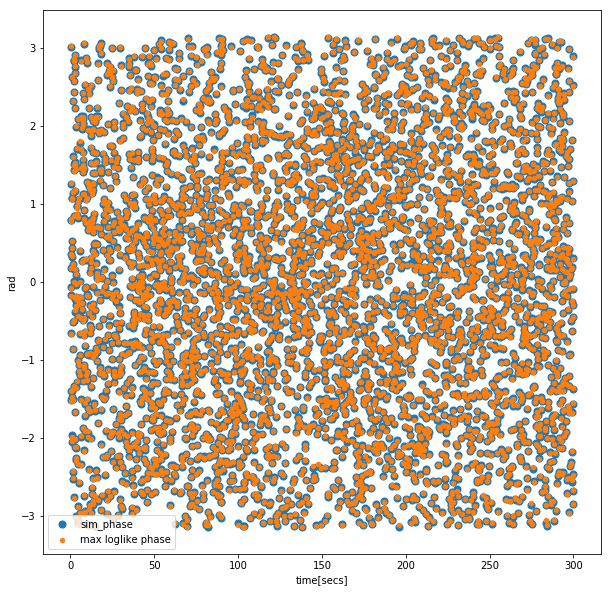

In [3]:
# Plots for theoretical par values:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plt.plot(t[:1000000], np.mod((theo_phase[:1000000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[-30000:],np.mod((task4.phase[-30000:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'sim_phase')
plt.scatter(task4.timestamp[-30000:], np.mod((phase[-30000:]+ np.pi),2*np.pi) - np.pi, s= 20,label = 'max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
#plt.xlim([3.4,4])
plt.legend()

In [3]:
# MLE for N set of par
# pos_t = (2,N,3)

QT = qua.QuaTel()
BSC = qua.BSC_process("/home/zhi/SULI21/bsc5.dat")

lam = 1*10**(-6)
#NEW YORK COORD but the overall baseline is E-W, with B ~ 190m
pos_t_NY = [[-1.3,0.71,6.4*10**(6)],[-1.30004,0.71,6.4*10**(6)]]   #Baseline vector in [RA,DEC,RADIUS]
pos = BSC.BSC_filter(pos_t_NY,3)
# Use some sample pos, here I use sample pos[0] as a sample star
print('pos16',pos[16])
T = 20000     # try for 3000s first

num, t, baseline, theo_phase, d_source = QT.get_num_photon(pos[16],pos_t_NY,lam,T,'pos')
f_t, new_t = QT.freq_func(theo_phase,t)
num = num[0] # Lets simulate data for one star only, and implement multiple stars if needed
theo_phase = theo_phase[0]

task4 = qua.sim_data(num*10,t,theo_phase,'pos')   
print('theo_d',d_source[0,0,:])




def MLE(par, t, pos_s, pos_t, lam,d,theo = 0):    # par = [[v,phi,theta],[v,phi,theta],...], let it be (M,3) set of par
    par = np.array(par)
    vis = np.tile(par[:,0],(t.size,1)).T                               # (M,N)
    ds = np.column_stack((par[:,1],par[:,2]))    # [ew,ns] [[phi,theta],[],[],[]...]   (M,2)
    
    def get_phase(t, ds, pos_s, pos_t,lam,d,theo):       
        pos_t = np.array(pos_t)
        pos_t[:,1] = np.pi/2 - pos_t[:,1]   # baseline vector in spherical baseline [[phi,theta,r],[phi,theta,r]]
        pos_s = np.delete(pos_s,0, axis=1)   #pos_s:[[[ra,dec,r],[ra,dec,r]],[[],[]]]
    
        pos_s[:,1] = np.pi/2 - pos_s[:,1]
        
        Omega_E = 7.292e-5
        lam = lam
        #let ds be differene of source unit vector
        #let baseline vector change as a func of time, + Omega instead of minus
    
        def pos_carte(pos, ti, d,theo,M=None,source= None):
            # rotate baseline vector as func of time
            if (ti == 0.).all():   # for pos source
                x = np.sin(source[:,1])*np.cos(source[:,0]) 
                y = np.sin(source[:,1])*np.sin(source[:,0])
                z = np.cos(source[:,1])
               
                r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
                s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    
                # close to theoretical d_ns and d_ew
                #d_ew = (s/r)*(source[0,0]-source[1,0])  # using midpoint

                #d_ew = np.sin(source[0,1])*source[0,0]-np.sin(source[1,1])*source[1,0]   #actual
                d_ew = s/r * pos[:,0]   
                
                #d_ew = pos[:,0] 
                
                print(source)
                #d_ns = (source[0,1] - source[1,1])  
                d_ns = pos[:,1]
             
                #converting to Earth coord
                #rotate around d_ew axis, y axis
                fin_z = (s/r)*d_ns    # (M)
                new_x = (((z[0]+z[1])/2)/r)*d_ns    #multiplied by d_ew and d_ns
                
                # rotate around z axis
                phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
                fin_x = np.cos(np.pi/2 + phi)*new_x - np.sin(-(np.pi/2 + phi))*d_ew   
                fin_y = np.sin(-(np.pi/2 + phi))*new_x + np.cos(np.pi/2 + phi)*d_ew   #(M)
                
                new_pos = -np.column_stack((fin_x,fin_y,fin_z))    #(M,3) weird sign issue: - sign needed
             
                
                #return d
                #print(diff)
                if theo != 0:
                    diff = d-new_pos
                    print('diff',diff)
                    #diff = np.array([ 2.91272659e-09, -9.51346830e-10,  1.66459994e-09])
                
                    #new_pos += diff
                
                
                return new_pos   #(M,3)
            
            N = ti.size                
            new_t = np.tile(ti,(M,2,1))   # (M,2,N)
            
            pos_tile = np.tile(np.reshape(pos,(1,2,1,3)),(M,1,N,1))    #pos of telescope, 2,N,3
            
            new_pos = np.zeros((M,2,N,3))
            
            #change from spherical to cartesian
            new_pos[:,:,:,0] = pos_tile[:,:,:,2]*np.sin(pos_tile[:,:,:,1])*np.cos(pos_tile[:,:,:,0] + Omega_E*new_t)   #[x,y,z](t)
            new_pos[:,:,:,1] = pos_tile[:,:,:,2]*np.sin(pos_tile[:,:,:,1])*np.sin(pos_tile[:,:,:,0] + Omega_E*new_t)
            new_pos[:,:,:,2] = pos_tile[:,:,:,2]*np.cos(pos_tile[:,:,:,1])     

            return new_pos
    
        ds_car = np.tile(pos_carte(ds, np.array([0.]), d,theo,source = pos_s).reshape(len(ds),1,3),(1,t.size,1)) #(M,N,3)
        #print('ds_car', ds_car)
        
        new_pos_t = pos_carte(pos_t,t, d,theo,M = len(ds))           #(M,2,N,3)
        baseline = new_pos_t[:,1,:,:] - new_pos_t[:,0,:,:]      #(M,N,3)
        #print('baseline shape', baseline.shape)
        print('dscar ', ds_car)
        print('baseline', baseline)
        dot = baseline[:,:,0]*ds_car[:,:,0] + baseline[:,:,1]*ds_car[:,:,1] + baseline[:,:,2]*ds_car[:,:,2]  #(M,N)
        phase = 2*np.pi/lam*dot
        
        return phase
    
    phase = get_phase(t,ds,pos_s,pos_t,lam,d,theo)
    loglike = np.log(1+vis*np.cos(phase))  #get loglike for diff phase in 2d array[[],[],[]...]
    
    
    return np.sum(loglike,axis= 1 ), phase

def theo_ds(pos, theo):  #pos in [#,phi,dec,s] find midpoint theta and phi.
    
    pos[:,2] = np.pi/2. - pos[:,2]
    print('theo_pos',pos)
    x = np.sin(pos[:,2])*np.cos(pos[:,1])
    y = np.sin(pos[:,2])*np.sin(pos[:,1])
    z = np.cos(pos[:,2])
    #print(x,y,z)
    r = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1],z[0]+z[1]])/2)
    s = np.linalg.norm(np.array([x[0]+x[1],y[0]+y[1]])/2)
    phi = math.atan2((x[0]+x[1]),(y[0]+y[1]))
    #d_ew = (s/r)*(pos[0,1]-pos[1,1])  # using midpoint
    #d_ew = np.sin(pos[0,2])*pos[0,1]-np.sin(pos[0,2])*pos[1,1]   #actual
    d_ra = (pos[0,1]-pos[1,1])     #+ 3.375e-9
    d_dec = (pos[0,2] - pos[1,2])  #- 2.89902e-9
    
    # Use theo d_source in cart to convert to d_ns and d_ew
    d_dec_theo = -theo[2]*r/s
    
    new_x = (((z[0]+z[1])/2)/r)*d_dec_theo
    
    d_ew_x = (theo[0]+np.cos(np.pi/2 + phi)*new_x)/(np.sin(-(np.pi/2 + phi)))
    
    d_ew_y = (-theo[1]-np.sin(-(np.pi/2 + phi))*new_x)/(np.cos(np.pi/2 + phi))
    
    d_ra_theo = d_ew_x*r/s    
    
    print('diff in RA', d_ra - d_ra_theo)
    print('diff in DEC', d_dec - d_dec_theo)
    
    return d_dec, d_ra, d_dec_theo, d_ra_theo


#a =theo_ds(pos[16],d_source[0,0,:])
#print(a)

#[0.0056273205,-0.001095679]
d_dec, d_ra, d_dec_theo, d_ra_theo = theo_ds(pos[16],d_source[0,0,:])
theo_par = [[task4.V,d_ra_theo,d_dec_theo]]
print('theo_par',theo_par)



pos = BSC.BSC_filter(pos_t_NY,3)
loglike,phase = MLE(theo_par,task4.timestamp,pos[16],pos_t_NY,lam,d_source[0,0,:],theo=1)

loglike


('pos16', array([[5.06200000e+03, 3.51345687e+00, 9.59722619e-01, 9.05944064e+01],
       [5.05400000e+03, 3.50778455e+00, 9.58626940e-01, 4.49884866e+02]]))
('theo_d', array([ 0.00201149, -0.00271418,  0.00062913]))
('theo_pos', array([[5.06200000e+03, 3.51345687e+00, 6.11073708e-01, 9.05944064e+01],
       [5.05400000e+03, 3.50778455e+00, 6.12169387e-01, 4.49884866e+02]]))
('diff in RA', -3.3750634838985993e-09)
('diff in DEC', 2.899018798673339e-09)
('theo_par', [[0.2790452774098804, 0.005672323444045146, -0.0010956818183263065]])
[[  3.51345687   0.61107371  90.59440639]
 [  3.50778455   0.61216939 449.88486577]]
('diff', array([[ 0.00000000e+00, -2.63244287e-16, -1.08420217e-19]]))
('dscar ', array([[[ 0.00201149, -0.00271418,  0.00062913],
        [ 0.00201149, -0.00271418,  0.00062913],
        [ 0.00201149, -0.00271418,  0.00062913],
        ...,
        [ 0.00201149, -0.00271418,  0.00062913],
        [ 0.00201149, -0.00271418,  0.00062913],
        [ 0.00201149, -0.00271418, 

array([78.8507435])

In [ ]:
 [[0.2790452774098797, 0.005672323443981662, -0.0010956818183275078

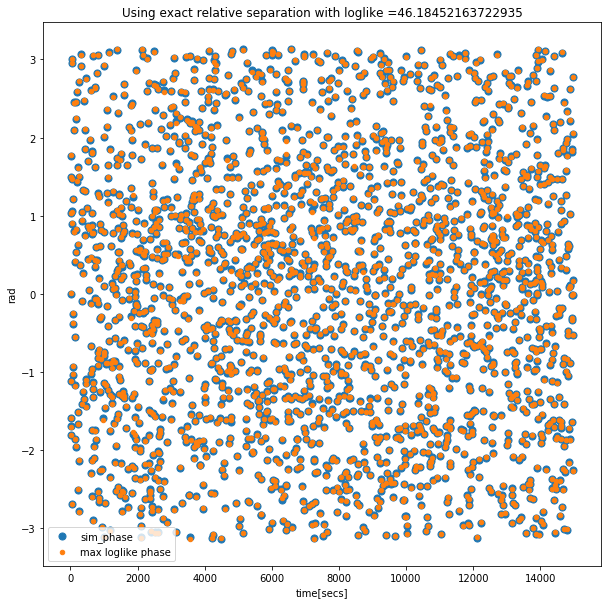

In [3]:
# Plots for theoretical par values:
plt.figure(figsize=(10,10))
#plt.subplot(2,2,1)
#plt.plot(t[:1000000], np.mod((theo_phase[:1000000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[-30000:],np.mod((task4.phase[-30000:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'sim_phase')
plt.scatter(task4.timestamp[-30000:], np.mod((phase[-30000:]+ np.pi),2*np.pi) - np.pi, s= 20,label = 'max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
plt.title('Using exact relative separation with loglike =' + np.str(loglike[0]))
#plt.xlim([3.4,4])
plt.legend()

In [4]:
# create an 2D ARRAY OF PARs
N = 30
M = task4.timestamp.size

d_ra_arr= np.ravel(np.tile(  np.linspace(d_ra_theo+17e-9, d_ra_theo-17e-9, N),(N**2,1)).T)   #pm 3e-9, 17
d_dec_arr= np.ravel(np.tile(  np.linspace(d_dec_theo+7e-9, d_dec_theo-7e-9, N), (N,N)).T)   #pm 1e-9, 7
V = np.tile(np.linspace(0.24, 0.30, N),(N**2))


#arr_range = np.linspace(0,N**3,20).astype(int)
start_index = 0
sum_loglike = np.array([])
#print('d_ra',d_ra.shape)
#print('d_dec', d_dec.shape)
#print('V', V.shape)

par = np.column_stack((V,d_ra_arr,d_dec_arr))

d_ra_arr = None
d_dec_arr = None
V = None

loglike,phase = MLE(par,task4.timestamp,pos[16],pos_t_NY,lam,d_source[0,0,:])  #loglike shape M, phase shape M,N
cond = np.where(loglike == np.amax(loglike))
print(cond)
print(np.amax(loglike))
print(par[np.where(loglike == np.amax(loglike))])
#print(par)

'''
for end_index in arr_range[1:]:
    #print(start_index)
    #print(end_index)
    L = end_index - start_index  #newly divided, total of L parameter pairs
    timestamp = np.tile(task4.timestamp,(L,1))
    d_ra_mat = np.tile(d_ra[start_index:end_index],(M,1)).T
    d_dec_mat = np.tile(d_dec[start_index:end_index],(M,1)).T
    V_mat = np.tile(V[start_index:end_index],(M,1)).T
    
    timestamp = task4.timestamp
    
    #par = np.column_stack((d_ra_mat))
    #print(A_mat)
    #print(w_mat)
    #print(theta_mat)
    #print(V_mat)
    
    
    sum_loglike = np.concatenate((sum_loglike, sum_log_likelihood(timestamp,d_ra_mat,d_dec_mat,theta_mat,V_fit)), axis=None)
    
    start_index = end_index
    
    timestamp = None
    d_ra_mat = None
    d_dec_mat = None
    V_mat = None
'''

[[  3.51345687   0.61107371  90.59440639]
 [  3.50778455   0.61216939 449.88486577]]
('dscar ', array([[[ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        ...,
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913]],

       [[ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        ...,
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913]],

       [[ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        ...,
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.00271419,  0.00062913],
        [ 0.00201149, -0.002

'\nfor end_index in arr_range[1:]:\n    #print(start_index)\n    #print(end_index)\n    L = end_index - start_index  #newly divided, total of L parameter pairs\n    timestamp = np.tile(task4.timestamp,(L,1))\n    d_ra_mat = np.tile(d_ra[start_index:end_index],(M,1)).T\n    d_dec_mat = np.tile(d_dec[start_index:end_index],(M,1)).T\n    V_mat = np.tile(V[start_index:end_index],(M,1)).T\n    \n    timestamp = task4.timestamp\n    \n    #par = np.column_stack((d_ra_mat))\n    #print(A_mat)\n    #print(w_mat)\n    #print(theta_mat)\n    #print(V_mat)\n    \n    \n    sum_loglike = np.concatenate((sum_loglike, sum_log_likelihood(timestamp,d_ra_mat,d_dec_mat,theta_mat,V_fit)), axis=None)\n    \n    start_index = end_index\n    \n    timestamp = None\n    d_ra_mat = None\n    d_dec_mat = None\n    V_mat = None\n'

In [5]:
#d_ew = 0.0056723220068981662
#d_ns = -0.0010956789193075078
#print(par[cond].shape)
# vary vis
cond1 = np.where(np.logical_and(par[:,1] == par[cond][0][1],par[:,2] == par[cond][0][2]))
# vary d_ra
cond2 = np.where(np.logical_and(par[:,0] == par[cond][0][0],par[:,2] == par[cond][0][2]))
# vary d_dec
cond3 = np.where(np.logical_and(par[:,0] == par[cond][0][0],par[:,1] == par[cond][0][1]))

par[cond2]
#print(np.unique(par[index][:,1:3],axis=0))

array([[ 0.3       ,  0.00567234, -0.00109568],
       [ 0.3       ,  0.00567234, -0.00109568],
       [ 0.3       ,  0.00567234, -0.00109568],
       [ 0.3       ,  0.00567234, -0.00109568],
       [ 0.3       ,  0.00567234, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567233, -0.00109568],
       [ 0.3       ,  0.00567232, -0.00109568],
       [ 0.3       ,  0.00567232, -0.00109568],
       [ 0.3       ,  0.00567232, -0.00109568],
       [ 0.3       ,  0.00567232, -0.00109568],
       [ 0.3       ,  0.00567232, -0.00109568],
       [ 0.3       ,  0.00567232, -0.00109568],
       [ 0.3       ,  0.00567232, -0.001

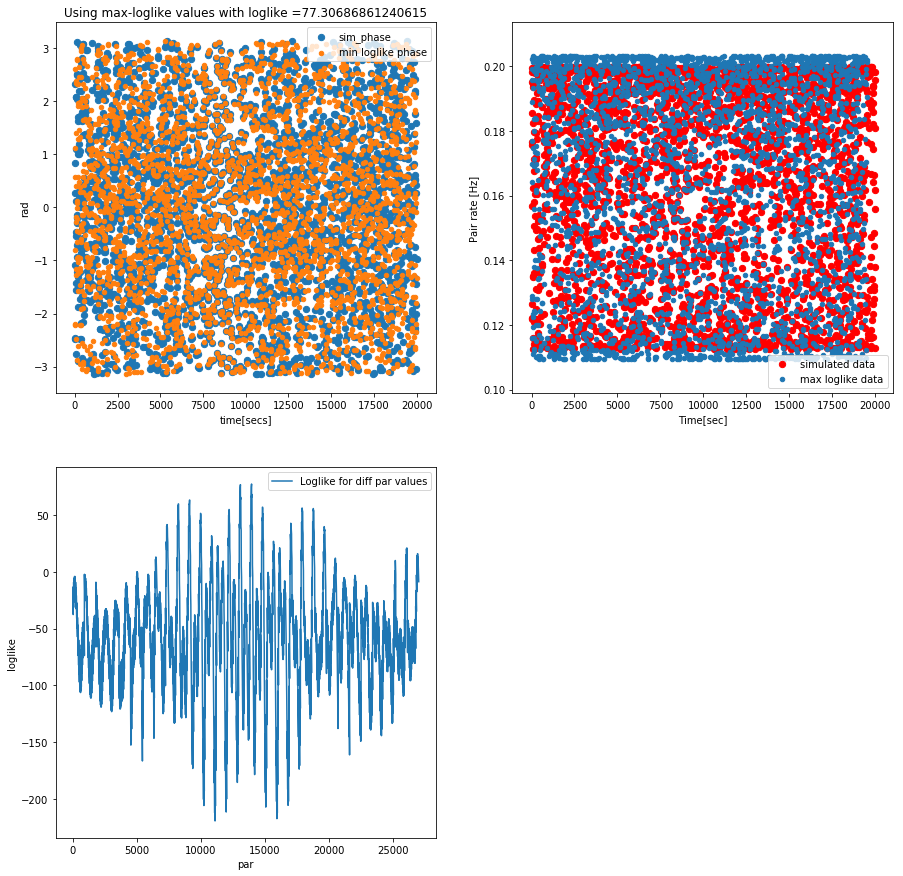

In [6]:
cond4 = np.where(loglike == np.amin(loglike))
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
#plt.plot(t[:1000000], np.mod((theo_phase[:1000000]+ np.pi),2*np.pi) - np.pi, color = 'g',label='theo phase curve')
plt.scatter(task4.timestamp[-30000:],np.mod((task4.phase[-30000:]+ np.pi),2*np.pi) - np.pi, s=40,label = 'sim_phase')
plt.scatter(task4.timestamp[-30000:], np.mod((phase[cond][0][-30000:]+ np.pi),2*np.pi) - np.pi, s=20,label = 'min loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')
plt.title('Using max-loglike values with loglike ='+ np.str(np.amax(loglike)) )
#plt.xlim([150.4,300])
plt.legend()
plt.subplot(2,2,2)
#plt.xlim([230.4, 233])
plt.scatter(task4.timestamp[:],task4.sim_num[:], s = 40, color='r', label ='simulated data')
#plt.plot(t[:1000000],num[:1000000]*10, label = 'theoretical curve')
plt.scatter(task4.timestamp[:3000],task4.avg_rate*(1+par[cond][0][0]*np.cos(phase[cond][0][:3000])), s=20,label = 'max loglike data')
plt.xlabel('Time[sec]');plt.ylabel('Pair rate [Hz]')
plt.legend()
plt.subplot(2,2,3)
index = np.where(par[:,0] == par[30,0])
plt.plot(loglike, label='Loglike for diff par values')
plt.xlabel('par');plt.ylabel('loglike')
plt.legend()

In [3]:
'''
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection = '3d')
img = ax.scatter(par[:,1],par[:,2],par[:,0],c=loglike, cmap = plt.hot())
plt.xlabel('d_RA');plt.ylabel('d_Dec')
fig.colorbar(img)
plt.show()
'''

"\n%matplotlib notebook\nfrom mpl_toolkits.mplot3d import Axes3D\nfrom matplotlib import cm\n\nfig = plt.figure(figsize=(10,10))\nax = fig.add_subplot(111,projection = '3d')\nimg = ax.scatter(par[:,1],par[:,2],par[:,0],c=loglike, cmap = plt.hot())\nplt.xlabel('d_RA');plt.ylabel('d_Dec')\nfig.colorbar(img)\nplt.show()\n"

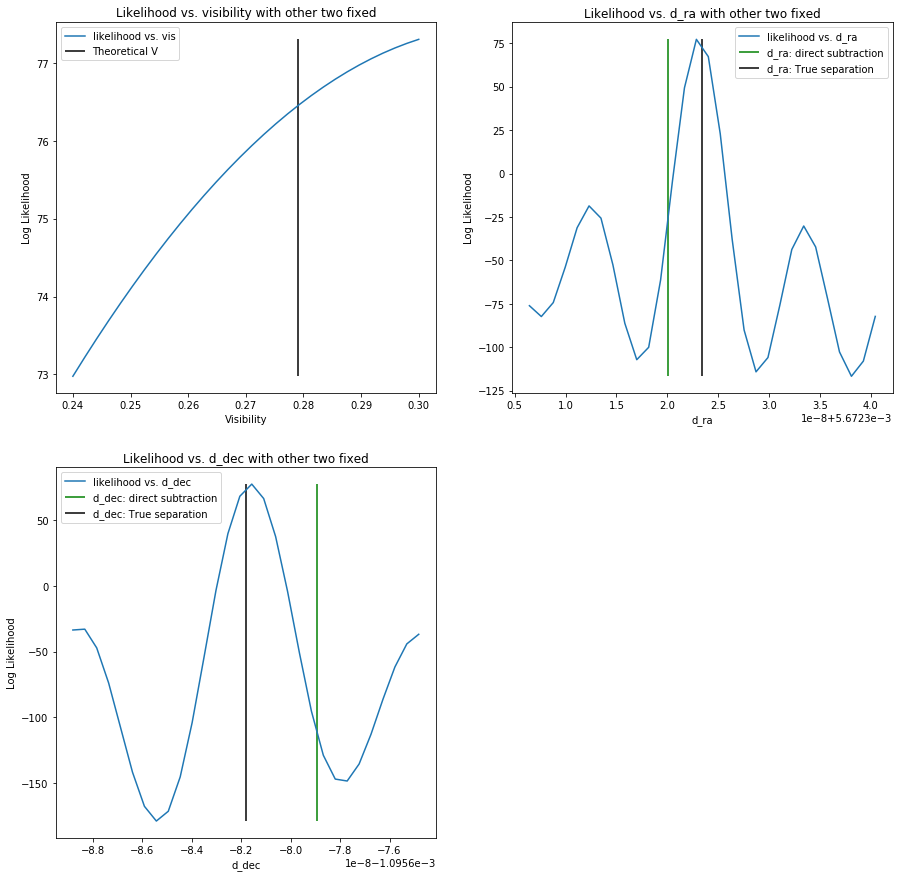

In [7]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
#plt.plot(par[cond1][:,0],np.exp(loglike[cond1]), label= 'likelihood vs. vis')
plt.plot(par[cond1][:,0],loglike[cond1], label= 'likelihood vs. vis')

plt.vlines(task4.V,np.amin(loglike[cond1]), np.amax(loglike[cond1]),label='Theoretical V')
#plt.vlines(task4.V,np.amin(np.exp(loglike[cond1])), np.amax(np.exp(loglike[cond1])),label='Theoretical V')
#plt.ylim([0.1,6]
plt.xlabel('Visibility');plt.ylabel('Log Likelihood')
plt.title('Likelihood vs. visibility with other two fixed')
plt.legend()

plt.subplot(2,2,2)
plt.plot(par[cond2][:,1],loglike[cond2], label = 'likelihood vs. d_ra')
#plt.plot(par[cond2][:,1],np.exp(loglike[cond2]), label = 'likelihood vs. d_ra')


#plt.vlines(d_ra,np.amin(np.exp(loglike[cond2])), np.amax(np.exp(loglike[cond2])),color='g',label='d_ra: direct subtraction')
#plt.vlines(d_ra_theo,np.amin(np.exp(loglike[cond2])), np.amax(np.exp(loglike[cond2])),label= 'd_ra: True separation')

plt.vlines(d_ra,np.amin(loglike[cond2]), np.amax(loglike[cond2]),color='g',label='d_ra: direct subtraction')
plt.vlines(d_ra_theo,np.amin(loglike[cond2]), np.amax(loglike[cond2]),label= 'd_ra: True separation')


plt.xlabel('d_ra');plt.ylabel('Log Likelihood')
plt.title('Likelihood vs. d_ra with other two fixed')
#plt.ylim([1.3e12,1.9e12]);
#plt.xlim([0.5e-8+5.6723e-3,4.0e-8+5.6723e-3])
#plt.ylim([15,30])
plt.legend()


plt.subplot(2,2,3)
plt.plot(par[cond3][:,2],loglike[cond3], label='likelihood vs. d_dec')
#plt.plot(par[cond3][:,2],np.exp(loglike[cond3]), label='likelihood vs. d_dec')

#plt.vlines(d_dec,np.amin(np.exp(loglike[cond3])), np.amax(np.exp(loglike[cond3])),color='g',label='d_dec: direct subtraction')
#plt.vlines(d_dec_theo,np.amin(np.exp(loglike[cond3])), np.amax(np.exp(loglike[cond3])),label='d_dec: True separation')


plt.vlines(d_dec,np.amin(loglike[cond3]), np.amax(loglike[cond3]),color='g',label='d_dec: direct subtraction')
plt.vlines(d_dec_theo,np.amin(loglike[cond3]), np.amax(loglike[cond3]),label='d_dec: True separation')

plt.xlabel('d_dec');plt.ylabel('Log Likelihood')
plt.title('Likelihood vs. d_dec with other two fixed')
#plt.ylim([1.3e12,1.9e12]);
#plt.xlim([-9e-8-1.0956e-3,-7.4e-8-1.0956e-3])
#plt.ylim([15,30])
plt.legend()
